In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def load_data(file_path):
    """
    Loads data from a CSV file and converts date columns to datetime format.

    Args:
        file_path (str): The path to the CSV file.

    Returns:
        pd.DataFrame: Loaded DataFrame with date columns converted to datetime.
    """
    df = pd.read_csv(file_path)
    df['Data_pomiaru'] = pd.to_datetime(df['Data_pomiaru'], errors='coerce')
    df['Data_ostatniej_awarii'] = pd.to_datetime(df['Data_ostatniej_awarii'], errors='coerce')
    df['Data_prawdziwej_awarii'] = pd.to_datetime(df['Data_prawdziwej_awarii'], errors='coerce')
    return df

In [6]:
def preprocess_data(df):
    """
    Processes data by adding numerical columns representing the number of days from a reference date.

    Args:
        df (pd.DataFrame): DataFrame containing raw data.

    Returns:
        tuple: (Processed DataFrame, reference date used for calculations)
    """
    reference_date = min(df['Data_pomiaru'].min(), df['Data_ostatniej_awarii'].min()) - pd.Timedelta(days=1)
    df['days_since_measurement'] = (df['Data_pomiaru'] - reference_date).dt.days
    df['days_since_last_failure'] = (df['Data_ostatniej_awarii'] - reference_date).dt.days
    df['days_until_true_failure'] = (df['Data_prawdziwej_awarii'] - reference_date).dt.days
    df['days_until_true_failure'].fillna(-1, inplace=True)
    return df, reference_date

In [7]:
def encode_features(df, categorical_columns, numerical_columns):
    """
    Encodes categorical features using OneHotEncoder and scales numerical features using StandardScaler.

    Args:
        df (pd.DataFrame): DataFrame containing data to encode.
        categorical_columns (list): List of categorical column names.
        numerical_columns (list): List of numerical column names.

    Returns:
        tuple: (Encoded and scaled features, OneHotEncoder object, StandardScaler object)
    """
    encoder = OneHotEncoder(sparse_output=False)
    encoded_categories = encoder.fit_transform(df[categorical_columns])
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[numerical_columns])
    features = np.concatenate([scaled_features, encoded_categories], axis=1)
    return features, encoder, scaler

In [8]:
def extract_constant_features(df, constant_columns):
    """
    Extracts constant features for each pipeline segment.

    Args:
        df (pd.DataFrame): DataFrame containing the data.
        constant_columns (list): List of column names that are constant for each segment.

    Returns:
        pd.DataFrame: DataFrame containing the extracted constant features.
    """
    return df.groupby('ID_odcinka', as_index=False)[constant_columns].first()

In [9]:
def encode_constant_features(context_features, categorical_columns, numerical_columns, df):
    """
    Encodes and scales constant features for each segment.

    Args:
        context_features (pd.DataFrame): DataFrame with constant features for each segment.
        categorical_columns (list): List of categorical columns to encode.
        numerical_columns (list): List of numerical columns to scale.
        df (pd.DataFrame): Original DataFrame used to fit encoders.

    Returns:
        tuple: (Encoded and scaled context features, OneHotEncoder object, StandardScaler object)
    """
    context_features_for_encoding = context_features.drop(columns=['ID_odcinka'])
    encoder_constant = OneHotEncoder(sparse_output=False).fit(df[categorical_columns])
    context_encoded = encoder_constant.transform(context_features_for_encoding[categorical_columns])
    context_scaler = StandardScaler().fit(df[numerical_columns])
    context_scaled = context_scaler.transform(context_features_for_encoding[numerical_columns])
    context_vectors = np.concatenate([context_scaled, context_encoded], axis=1)
    return context_vectors, encoder_constant, context_scaler

In [10]:
def create_sequences(df, features, context_vectors, context_features, reference_date):
    """
    Creates sequences of input data for the model based on pipeline segment IDs.

    Args:
        df (pd.DataFrame): DataFrame with data.
        features (np.ndarray): Encoded and scaled input features.
        context_vectors (np.ndarray): Encoded and scaled context features.
        context_features (pd.DataFrame): DataFrame containing constant features.
        reference_date (pd.Timestamp): Reference date used for date calculations.

    Returns:
        tuple: (Lists of input sequences, context sequences, target values)
    """
    X_seq, y_seq, context_seq = [], [], []

    for segment_id in df['ID_odcinka'].unique():
        segment_data = df[df['ID_odcinka'] == segment_id]
        sequence_length = min(180, len(segment_data))
        if len(segment_data) < sequence_length:
            continue
        segment_indices = segment_data.index[:sequence_length]
        segment_features = features[segment_indices]
        if segment_id in context_features['ID_odcinka'].values:
            context_index = context_features[context_features['ID_odcinka'] == segment_id].index[0]
            context_vector = context_vectors[context_index]
        else:
            continue
        future_failure_date = segment_data['days_until_true_failure'].iloc[-1]
        if pd.isna(future_failure_date) or future_failure_date == -1:
            continue
        X_seq.append(segment_features)
        context_seq.append(context_vector)
        y_seq.append(future_failure_date)
    
    return X_seq, context_seq, y_seq

In [11]:
class TransformerModel(nn.Module):
    """
    Transformer-based model for predicting pipeline failures.
    """
    def __init__(self, input_size, context_size, d_model, nhead, num_encoder_layers, dim_feedforward):
        """
        Initializes the TransformerModel.

        Args:
            input_size (int): Size of the input features.
            context_size (int): Size of the context features.
            d_model (int): The number of expected features in the encoder inputs.
            nhead (int): The number of heads in the multiheadattention models.
            num_encoder_layers (int): The number of sub-encoder-layers in the encoder.
            dim_feedforward (int): The dimension of the feedforward network model.
        """
        super(TransformerModel, self).__init__()
        self.context_embedding = nn.Linear(context_size, d_model)
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=num_encoder_layers)
        self.fc_out = nn.Linear(d_model, 1)

    def forward(self, x, context):
        """
        Forward pass for the model.

        Args:
            x (torch.Tensor): Input sequences.
            context (torch.Tensor): Context vectors.

        Returns:
            torch.Tensor: Predicted values.
        """
        x = self.embedding(x)
        context = self.context_embedding(context).unsqueeze(1).repeat(1, x.size(1), 1)
        x = x + context
        x = self.transformer_encoder(x)
        return self.fc_out(x[:, -1, :])

In [12]:
def custom_loss(y_pred, y_true):
    """
    Custom loss function with penalties for incorrect predictions.

    Args:
        y_pred (torch.Tensor): Predicted values by the model.
        y_true (torch.Tensor): Actual target values.

    Returns:
        torch.Tensor: Computed loss value.
    """
    loss = torch.nn.MSELoss()(y_pred, y_true)
    penalty_late = torch.mean(torch.relu(y_pred - y_true))
    penalty_early = torch.mean(torch.relu(30 - (y_true - y_pred)))
    return loss + penalty_late + penalty_early

In [13]:
def train_model(model, optimizer, X_train_seq, y_train_seq, context_train_seq, num_epochs):
    """
    Trains the model for a specified number of epochs.

    Args:
        model (TransformerModel): The model to be trained.
        optimizer (torch.optim.Optimizer): The optimizer used for training.
        X_train_seq (torch.Tensor): Input training data sequences.
        y_train_seq (torch.Tensor): Target training values.
        context_train_seq (torch.Tensor): Contextual data for training.
        num_epochs (int): The number of training epochs.
    """
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_seq, context_train_seq).squeeze()
        loss = custom_loss(outputs, y_train_seq)
        loss.backward()
        optimizer.step()
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

In [14]:
def evaluate_model(model, X_test_seq, context_test_seq, y_test_seq, y_scaler, reference_date):
    """
    Evaluates the model and visualizes the results.

    Args:
        model (TransformerModel): The model to evaluate.
        X_test_seq (torch.Tensor): Input test data sequences.
        context_test_seq (torch.Tensor): Contextual data for testing.
        y_test_seq (torch.Tensor): Target test values.
        y_scaler (StandardScaler): Scaler used to inverse transform the target values.
        reference_date (pd.Timestamp): Reference date for converting predicted days into actual dates.
    """
    model.eval()
    with torch.no_grad():
        predictions = model(X_test_seq, context_test_seq).cpu().numpy().flatten()
        predicted_days = y_scaler.inverse_transform(predictions.reshape(-1, 1)).flatten().astype(int)
        predicted_dates = [reference_date + pd.to_timedelta(day, unit='D') for day in predicted_days]
        actual_days = y_scaler.inverse_transform(y_test_seq.cpu().numpy().reshape(-1, 1)).flatten().astype(int)
        actual_dates = [reference_date + pd.to_timedelta(day, unit='D') for day in actual_days]

    visualization_data = pd.DataFrame({
        'Predicted Failure Date': predicted_dates,
        'Actual Failure Date': actual_dates
    })
    print("\nPrzykładowe prognozy vs. rzeczywiste daty awarii:")
    print(visualization_data.head(20))

    plt.figure(figsize=(12, 6))
    plt.plot(predicted_dates[:20], label='Predicted Failure Dates', marker='o', linestyle='--')
    plt.plot(actual_dates[:20], label='Actual Failure Dates', marker='x', linestyle='-')
    plt.xlabel('Samples')
    plt.ylabel('Failure Dates')
    plt.legend()
    plt.title('Comparison of Predicted and Actual Failure Dates')
    plt.show()


In [15]:
data_path = 'water_supply_failure_features_database.csv'
df = load_data(data_path)
df, reference_date = preprocess_data(df)

In [16]:
categorical_columns = ['Materiał', 'Rodzaj_gruntu', 'Kategoria_ruchu']
numerical_columns = ['Długość_odcinka', 'Wiek_rury', 'Średnica', 'Ciśnienie', 'Przepływ', 'pH_wody', 'days_since_measurement', 'days_since_last_failure']
features, encoder, scaler = encode_features(df, categorical_columns, numerical_columns)

In [17]:
constant_columns = ['ID_odcinka'] + categorical_columns + ['Średnica', 'Wiek_rury', 'Długość_odcinka']
context_features = extract_constant_features(df, constant_columns)
context_vectors, encoder_constant, context_scaler = encode_constant_features(context_features, categorical_columns, ['Średnica', 'Wiek_rury', 'Długość_odcinka'], df)

In [18]:
X_seq, context_seq, y_seq = create_sequences(df, features, context_vectors, context_features, reference_date)
X_seq = torch.tensor(np.array(X_seq), dtype=torch.float32).to(device)
context_seq = torch.tensor(np.array(context_seq), dtype=torch.float32).to(device)
y_seq = torch.tensor(np.array(y_seq), dtype=torch.float32).to(device)

In [19]:
y_scaler = StandardScaler()
y_seq_scaled = y_scaler.fit_transform(y_seq.cpu().numpy().reshape(-1, 1)).flatten()
y_seq = torch.tensor(y_seq_scaled, dtype=torch.float32).to(device)

In [20]:
X_train_seq, X_test_seq, y_train_seq, y_test_seq, context_train_seq, context_test_seq = train_test_split(X_seq, y_seq, context_seq, test_size=0.2, random_state=42)

In [21]:
input_size = X_train_seq.shape[2]
context_size = context_train_seq.shape[1]
model = TransformerModel(input_size, context_size, d_model=128, nhead=8, num_encoder_layers=4, dim_feedforward=512).to(device)

In [22]:
optimizer = optim.Adam(model.parameters(), lr=0.0005)
num_epochs = 100
train_model(model, optimizer, X_train_seq, y_train_seq, context_train_seq, num_epochs)

d:\Projects\Aiut\.venv\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch [1/100], Loss: 31.5046
Epoch [2/100], Loss: 31.4908
Epoch [3/100], Loss: 30.3241
Epoch [4/100], Loss: 30.5123
Epoch [5/100], Loss: 30.3086
Epoch [6/100], Loss: 29.9047
Epoch [7/100], Loss: 30.0418
Epoch [8/100], Loss: 30.1082
Epoch [9/100], Loss: 29.9272
Epoch [10/100], Loss: 29.8590
Epoch [11/100], Loss: 29.9666
Epoch [12/100], Loss: 29.9155
Epoch [13/100], Loss: 29.8282
Epoch [14/100], Loss: 29.7953
Epoch [15/100], Loss: 29.8494
Epoch [16/100], Loss: 29.8615
Epoch [17/100], Loss: 29.8572
Epoch [18/100], Loss: 29.8188
Epoch [19/100], Loss: 29.8212
Epoch [20/100], Loss: 29.8252
Epoch [21/100], Loss: 29.8248
Epoch [22/100], Loss: 29.8118
Epoch [23/100], Loss: 29.7769
Epoch [24/100], Loss: 29.7855
Epoch [25/100], Loss: 29.7930
Epoch [26/100], Loss: 29.8177
Epoch [27/100], Loss: 29.7935
Epoch [28/100], Loss: 29.7766
Epoch [29/100], Loss: 29.7876
Epoch [30/100], Loss: 29.7855
Epoch [31/100], Loss: 29.7894
Epoch [32/100], Loss: 29.7748
Epoch [33/100], Loss: 29.7642
Epoch [34/100], Los


Przykładowe prognozy vs. rzeczywiste daty awarii:
   Predicted Failure Date Actual Failure Date
0              1959-03-05          1962-09-13
1              1953-02-06          1955-11-22
2              1921-04-26          1927-08-26
3              1935-03-08          1940-10-25
4              1913-05-04          1921-09-16
5              1910-07-14          1932-10-02
6              1922-11-01          1935-04-25
7              1981-11-20          2004-08-29
8              1969-08-28          1973-01-20
9              1929-11-14          1954-07-23
10             1918-05-21          1939-01-13
11             1994-09-07          2006-01-11
12             1940-08-09          1945-02-26
13             1971-07-11          1993-03-30
14             1964-09-03          1992-11-17
15             1913-07-13          1927-04-17
16             1902-03-08          1914-09-13
17             1938-07-10          1949-11-20
18             1972-07-19          2003-10-19
19             1914-02-01    

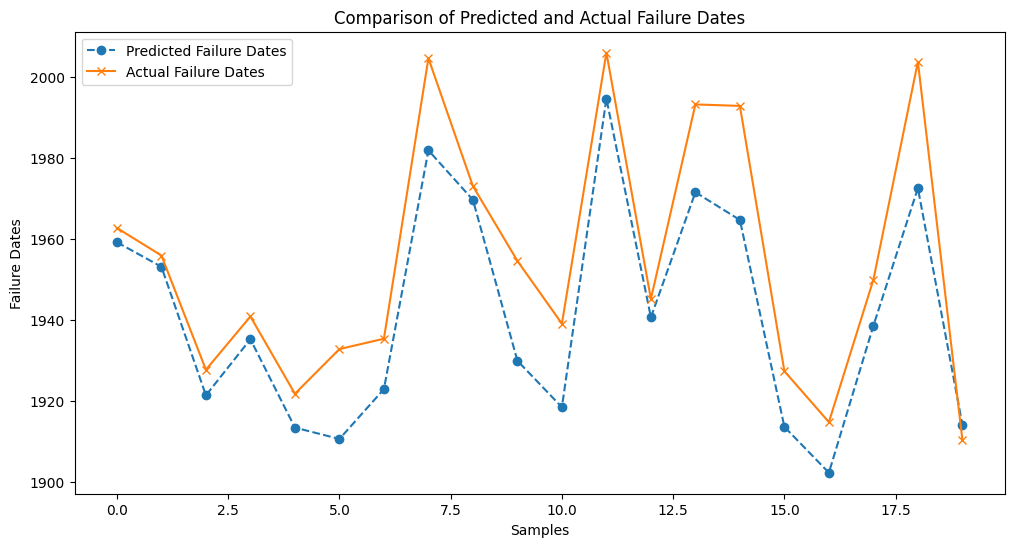

In [23]:
evaluate_model(model, X_test_seq, context_test_seq, y_test_seq, y_scaler, reference_date)